# Practical Example: Data analysis and visualization of USGS stream data

In this example we will use stream gage data from the USGS to perform some data analysis and data visualization.

We will be comparing two USGS gages, one along the James at [Cartersville, VA](https://waterdata.usgs.gov/nwis/inventory?agency_code=USGS&site_no=02035000) and the other at [Richmond, VA](https://waterdata.usgs.gov/nwis/inventory?agency_code=USGS&site_no=02037500)

In [1]:
#import necessary libraries

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
import pandas as pd

from IPython.display import display

### Installing packages

In addition to the libraries that are already built in to Google Colab, we will be using the ```dataretrieval``` package from USGS to directly obtain streamflow data. More info on this package and its functionalities can be found on the [USGS github site](https://doi-usgs.github.io/dataretrieval-python/index.html) and on [Hydroshare.org](https://www.hydroshare.org/resource/c97c32ecf59b4dff90ef013030c54264/)

This package is not preinstalled in Google Colab, but we can install it by running ```!pip install dataretrieval```

Since Google Colab is a web-based Python IDE, you will have to install any non-preinstalled libraries anytime you want to use them. If you are using a local IDE, you only have to do this once.

In [2]:
!pip install dataretrieval

###Importing Data

First, we will import data from a .txt file that has already been downloaded from the USGS National Water Information System (NWIS).

Download 'JAMES_RVA_DAILYQ.txt' from https://github.com/bfwinter/pythonintro. This is daily flow data from the James river between 1/1/2020 and 12/31/2023.

If this notebook is open locally through Jupyter or another IDE, save the .txt file in the same directory as the notebook (this makes things easier).

If you are using Google Colab, upload the .txt file by clicking the file icon on the left, choosing a location, and clicking the upload icon. I chose to save mine in the my Google Drive.

In [4]:
#import the .txt file as a dataframe
#copy the file path and make sure .txt is at the end
#the delimiter \t means that it's a tab-seperated document
#skiprows skips the metadata at the top. open the .txt by itself to see this

RVA_RAW_Q = pd.read_csv('/content/drive/MyDrive/example_discharge_data.txt', delimiter='\t', skiprows=28)

#check the dataframe to make sure it came in alright
#display the beginning (head) of the dataframe as a quick check
print(RVA_RAW_Q.head())

  agency_cd   site_no    datetime 145310_00060_00003 145310_00060_00003_cd
0        5s       15s         20d                14n                   10s
1      USGS  02037500  2020-01-01               4790                     A
2      USGS  02037500  2020-01-02               4380                     A
3      USGS  02037500  2020-01-03               3970                     A
4      USGS  02037500  2020-01-04               3900                     A


In [5]:
#this dataframe is still a little messy, lets just take the datetime
#and flow rows from row 1 to the end (since row 0 isn't data)

Rich_discharge = RVA_RAW_Q.iloc[1:, 2:4]

#lets rename the columns to our liking
Rich_discharge.rename(columns={Rich_discharge.columns[0]: 'Date', Rich_discharge.columns[1]: 'Richmond_Daily_Q'}, inplace=True)

print(Rich_discharge.head())

         Date Richmond_Daily_Q
1  2020-01-01             4790
2  2020-01-02             4380
3  2020-01-03             3970
4  2020-01-04             3900
5  2020-01-05             4120


In [6]:
#the data looks numeric right? check the datatypes

print(Rich_discharge['Date'].dtype)
print(Rich_discharge['Richmond_Daily_Q'].dtype)

object
object


In [7]:
#convert the column to numbers
Rich_discharge['Richmond_Daily_Q'] = pd.to_numeric(Rich_discharge['Richmond_Daily_Q'], errors='coerce')

#convert the date to dates
Rich_discharge['Date'] = pd.to_datetime(Rich_discharge['Date'])

#NOTE: these two functions are altering the input dataframe without creating a new one
#therefore, if previous code blocks that created the data frame are rerun, then
#the changes will be replaced with the original

###Retrieving Data

Now let's retrieve the data directly from the USGS NWIS using the ```dataretrieval``` library we loaded earlier...

In [8]:
from dataretrieval import nwis

# Set the parameters needed to retrieve data

#identify the site number for the Cartersville James River gage
siteNumber = "02035000"

#each gage parameter has a unique code
parameterCode = "00060"

#start and end date for the data retrieval
startDate = "2020-01-01"
endDate = "2023-12-31"

# Retrieve the data
dailyStreamflow = nwis.get_dv(sites=siteNumber, parameterCd=parameterCode, start=startDate, end=endDate)
print("Retrieved " + str(len(dailyStreamflow[0])) + " data values.")

Retrieved 1461 data values.


In [9]:
#the data comes in as a tuple (pair of data) where the first item is the
#dataframe and the second item is the metadata

#check that the dataframe came in correctly
display(dailyStreamflow[0])

,00060_Mean,00060_Mean_cd,site_no
datetime,,,
2020-01-01 00:00:00+00:00,4120.0,"A, e",02035000
2020-01-02 00:00:00+00:00,3650.0,A,02035000
2020-01-03 00:00:00+00:00,3500.0,A,02035000
2020-01-04 00:00:00+00:00,3460.0,"A, e",02035000
2020-01-05 00:00:00+00:00,3600.0,"A, e",02035000
...,...,...,...
2023-12-27 00:00:00+00:00,3390.0,P,02035000
2023-12-28 00:00:00+00:00,7200.0,P,02035000
2023-12-29 00:00:00+00:00,7760.0,P,02035000


In [11]:
#there are a couple changes we can make so that the two dataframes we
#made play together nicely

CARTER_RAW_Q = dailyStreamflow[0]

#create a standalone dataframe with the discharge data
Cart_discharge = CARTER_RAW_Q.iloc[0:, 0:1]

#currently, the index is the datatime column, let's change this so
#we can simplify the datetime to just the date
Cart_discharge.reset_index(inplace=True)

# Extract only the date component and ensure in date format
Cart_discharge['datetime'] = pd.to_datetime(Cart_discharge['datetime'].dt.date)

#rename columns
Cart_discharge.rename(columns={Cart_discharge.columns[0]: 'Date', Cart_discharge.columns[1]: 'Cartersville_Daily_Q'}, inplace=True)

print(Cart_discharge.head())

        Date  Cartersville_Daily_Q
0 2020-01-01                4120.0
1 2020-01-02                3650.0
2 2020-01-03                3500.0
3 2020-01-04                3460.0
4 2020-01-05                3600.0


###Merging Data

In [12]:
#now that both dataframes are in the same format, we can merge the dates together
James_discharge = pd.merge(Rich_discharge, Cart_discharge, on='Date', how='outer')

# Display the merged DataFrame
print(James_discharge.head())

        Date  Richmond_Daily_Q  Cartersville_Daily_Q
0 2020-01-01              4790                4120.0
1 2020-01-02              4380                3650.0
2 2020-01-03              3970                3500.0
3 2020-01-04              3900                3460.0
4 2020-01-05              4120                3600.0


In [13]:
start_date = '2020-01-01'
end_date =  '2020-01-31'

Jan_df = James_discharge[(James_discharge.iloc[:, 0] >= start_date) & (James_discharge.iloc[:, 0] <= end_date)]

print(Jan_df)

         Date  Richmond_Daily_Q  Cartersville_Daily_Q
0  2020-01-01              4790                4120.0
1  2020-01-02              4380                3650.0
2  2020-01-03              3970                3500.0
3  2020-01-04              3900                3460.0
4  2020-01-05              4120                3600.0
5  2020-01-06              4130                3550.0
6  2020-01-07              3990                3410.0
7  2020-01-08              3970                3460.0
8  2020-01-09              4090                3660.0
9  2020-01-10              4110                3540.0
10 2020-01-11              3900                3400.0
11 2020-01-12              3980                4300.0
12 2020-01-13              8300               11400.0
13 2020-01-14             14300               14000.0
14 2020-01-15             17700               15300.0
15 2020-01-16             14300               11100.0
16 2020-01-17             10800                8690.0
17 2020-01-18              8

In [14]:
#we can also perform quick summary statistics for each column
James_discharge.describe()

,Richmond_Daily_Q,Cartersville_Daily_Q
count,1461.000000,1461.000000
mean,7579.945243,7061.786448
std,8511.048074,7930.619352
min,1080.000000,1080.000000
25%,2560.000000,2410.000000
50%,5010.000000,4640.000000
75%,8880.000000,8180.000000
max,99300.000000,95700.000000


## Plotting the data

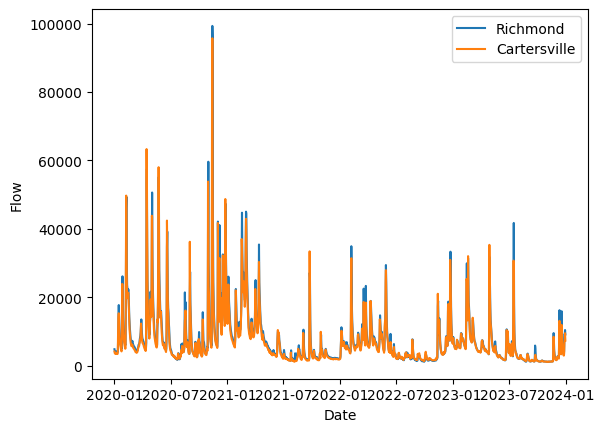

In [15]:
#let's see what the default plot looks like

fig,ax = plt.subplots()
ax.plot(James_discharge['Date'], James_discharge['Richmond_Daily_Q'], label = 'Richmond')
ax.plot(James_discharge['Date'], James_discharge['Cartersville_Daily_Q'], label = 'Cartersville')

ax.set_xlabel('Date')
ax.set_ylabel('Flow')
plt.legend()

plt.show()

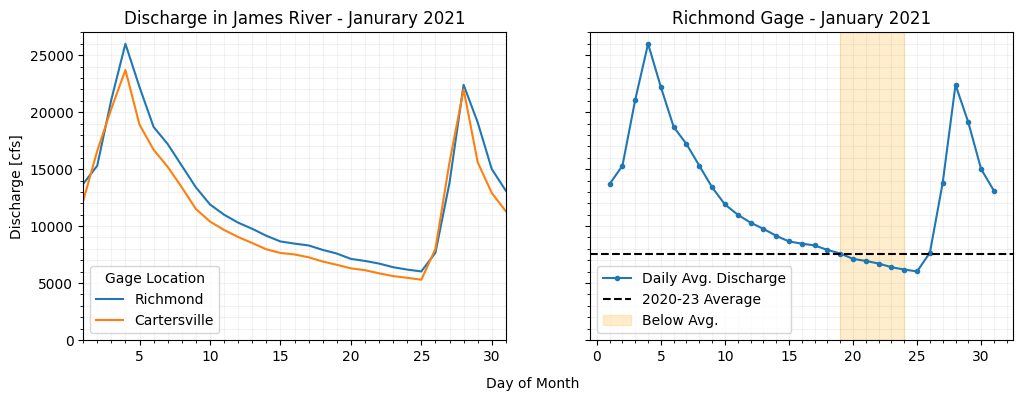

In [130]:
#let's make a more complicated plot for January 2021

jan21_data = James_discharge[(James_discharge['Date'].dt.year == 2021) & (James_discharge['Date'].dt.month == 1)]
day_of_month = jan21_data['Date'].dt.day

#find the intervals where the Richmond gage was below the year's average
Rich_avg = James_discharge['Richmond_Daily_Q'].mean()
mask_below_avg = jan21_data['Richmond_Daily_Q'] < Rich_avg

#create empy lists to put intervals in

below_intervals, below_intervals_date = [], []
start_point = None

# iterate over mask to see what indexes are "true" then convert to dates
for i, value in enumerate(mask_below_avg):
    if value and start_point is None:
        start_point = i
    elif not value and start_point is not None:
        end_point = i - 1
        below_intervals.append((start_point, end_point))
        below_intervals_date.append((jan21_data.iloc[start_point]['Date'], jan21_data.iloc[end_point]['Date']))
        start_point = None

# Append the last interval if start_point is not None after the loop
if start_point is not None:
    end_point = len(jan21_data) - 1
    below_intervals.append((start_point, end_point))
    below_intervals_date.append((jan21_data.iloc[start_point]['Date'], jan21_data.iloc[end_point]['Date']))


# set up a subplot so we can make multiple graphs
fig,ax = plt.subplots(1, 2, sharey = True, figsize = (12,4))

#plot richmond and cartersville for january
ax[0].plot(day_of_month, jan21_data['Richmond_Daily_Q'], label = 'Richmond')
ax[0].plot(day_of_month, jan21_data['Cartersville_Daily_Q'], label = 'Cartersville')
ax[0].set_ylim(0,)
ax[0].set_xlim(1,31)
ax[0].set_ylabel('Discharge [cfs]')

#add gridlines
ax[0].minorticks_on()
ax[0].xaxis.set_minor_locator(plt.MultipleLocator(1))
ax[0].yaxis.set_minor_locator(plt.MultipleLocator(1000))
ax[0].grid(True, color = 'gray', linestyle = '-', alpha = 0.1, which = 'both')

#add title and legend
ax[0].set_title("Discharge in James River - Janurary 2021")
ax[0].legend(loc = "lower left", ncol = 1, title = "Gage Location")

#plot richmond discharge with horizontal line for the average discharge
ax[1].plot(day_of_month, jan21_data['Richmond_Daily_Q'], label = 'Daily Avg. Discharge', marker = '.')
ax[1].axhline(y = Rich_avg, label = '2020-23 average', linestyle = '--', color = 'black')

#add gridlines
ax[1].minorticks_on()
ax[1].xaxis.set_minor_locator(plt.MultipleLocator(1))
ax[1].yaxis.set_minor_locator(plt.MultipleLocator(1000))
ax[1].grid(True, color = 'gray', linestyle = '-', alpha = 0.1, which = 'both')

#shade in interval where the daily average is below the yearly average
for interval in below_intervals:
  ax[1].axvspan(interval[0], interval[1], color='orange', alpha=0.2)

#you have to create a special label and "patch" to add the shaded region in the legend
shaded_label = 'Below Avg.'
shaded_patch = mpatches.Patch(color='orange', alpha=0.2, label=shaded_label)
handles = [ ax[1].lines[0], ax[1].lines[1], shaded_patch]
labels = ["Daily Avg. Discharge", "2020-23 Average", shaded_label]
ax[1].legend( handles=handles, labels=labels, loc = 'lower left')
ax[1].set_title("Richmond Gage - January 2021")

#add a common xlabel text to the bottom
fig.text(0.5, 0, 'Day of Month', ha='center', va='center')

plt.show()


## Automating the outputs

That seemed like a lot of work just to get some tables and plot some graphs...

But what if this was something that you knew you'd have to do frequently, or had a list of gages that you needed data from to compare?

In [16]:
from dataretrieval import nwis
import pandas as pd

#define a function to repeat all of the data shaping we did before

def discharge_data(site_data, parameter, startdate, enddate):
  result_df = pd.DataFrame()

  for site_no, site_name in site_data.items():

    data = nwis.get_dv(sites=site_no, parameterCd=parameter, start=startdate, end=enddate)
    data_df = data[0]

    df = data_df.iloc[0:, 0:1]
    df.reset_index(inplace=True)
    df['datetime'] = pd.to_datetime(df['datetime'].dt.date)
    df.rename(columns={df.columns[0]: 'Date', df.columns[1]: site_name}, inplace=True)

    if result_df.empty:
      result_df = df
    else:
      result_df = pd.merge(result_df, df, on='Date', how='outer')

  return result_df

#create a data dictionary for the input site data
site_data = {'02037500': 'James at Richmond',
             '02035000': 'James at Cartersville'}

#specify other parameters
parameter = "00060"
start = "2020-01-01"
end = "2023-12-31"

#run function and display results
results = discharge_data(site_data, parameter, start, end)

print(results)

           Date  James at Richmond  James at Cartersville
0    2020-01-01             4790.0                 4120.0
1    2020-01-02             4380.0                 3650.0
2    2020-01-03             3970.0                 3500.0
3    2020-01-04             3900.0                 3460.0
4    2020-01-05             4120.0                 3600.0
...         ...                ...                    ...
1456 2023-12-27             4180.0                 3390.0
1457 2023-12-28             9110.0                 7200.0
1458 2023-12-29             9080.0                 7760.0
1459 2023-12-30            10400.0                 9470.0
1460 2023-12-31             9110.0                 7320.0

[1461 rows x 3 columns]


The same automation can be applied to making graphs, output Excel files, summary statistics, etc.

Play around with the various options for graphing and display - if you think Python _should_ be able to do something - just Google how to do it!